<a href="https://colab.research.google.com/github/ResByte/pytorch-gan/blob/master/dcgan_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Conv GAN
The structure for DCGAN : 
1. Generator: takes in random noise of fixed dimension and creates image of desired size 
2. Discriminator : takes image of desired size from either real image dataset or fake dataset and classifies them into real or fake 

In [0]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets 
from torchvision import transforms
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from IPython import display

def set_default(figsize=(10, 10)):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize)

set_default(figsize=(15,15))

In [0]:
# initialize weights for any CNN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# testing a created model 
def test_model(model_class, shape=[1, 100, 1, 1]):
    model = model_class()
    x = torch.randn(shape)
    out = model(x)
    print(out.shape)
    

In [0]:
class Gen(nn.Module):
    r"""Generator network for DCGAN. 
    
    Parameters
    ----------
    z_dims : int, optional 
            input latent dimension size, default value for mnist
    filters: int, optional
            base multiple for number of convolutional kernels 
    out_channels : int, optional 
            output image number of channels,  defualt 1 for mnist
    """
    def __init__(self, z_dims=100,filters=32,out_channels=1):
        super(Gen, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dims, filters*4, kernel_size=4, 
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(filters*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters*4, filters*2, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters*2, filters, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters, out_channels, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh(),
            )
        self.apply(weights_init)
    def forward(self, x):
        return self.net(x)
        

In [0]:
class Disc(nn.Module):
    r"""Discriminator model for GAN. 
    Takes in image and predicts probability of fake
    
    Parameters
    ----------
    in_channels : int, optional 
        number of channels for input image, default 1 for MNIST 
    out_dims : int, optional 
        categories for classifying the output, 
        default 1 for prob of real or fake 
    filters : int, optional 
        base number of conv kernels, 
        each level kernels are factor of this base  
    
    """
    def __init__(self,in_channels=1, out_dims=1, filters=32):
        super(Disc, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=filters,
                      kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=filters,out_channels=filters*2,
                      kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=filters*2,out_channels=filters*4,
                      kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=filters*4,out_channels=out_dims,
                      kernel_size=4,stride=1, padding=0, bias=False),
            )
        self.apply(weights_init)
        
    def forward(self, x):
        return self.main(x)

In [5]:
test_model(Disc, shape=[1,1,32,32])

torch.Size([1, 1, 1, 1])


## Dataset Setup : MNIST / SVHN

In [0]:
def get_datasets(img_size=32):
    mnist_transform = transforms.Compose([
                        transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))])
    
    mnist_dataset_train = datasets.MNIST(root='./data', train=True, 
                                         transform=mnist_transform, download=True)
    
    svhn_transform = transforms.Compose([
                        transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    svhn_dataset_train = datasets.SVHN(root='./data',split='train', 
                                       transform=svhn_transform,download=True)
    print("mnist size:{} , svhn size:{}".format(len(mnist_dataset_train),len(svhn_dataset_train)))
    return mnist_dataset_train, svhn_dataset_train

def create_dataloaders(kind='mnist', img_size=32, batch_size=64, num_workers=1):
    mnist_dataset, svhn_dataset = get_datasets(img_size)
    
    mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=num_workers)
    svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=num_workers)
    if kind == 'mnist':
        return mnist_loader
    else:
        return svhn_loader
    

## DCGAN Solver

In [0]:
class DCGAN():
    r"""Deep Convolutional GAN 
    This creates network and performs training for mnist or svhn datasets 
    
    Args:
    ----------
    config : dict
        configuration dictionary consisting of parameters for training
        example config for mnist dataset : 
        ```python
        config = {
            'batch_size':32,
            'z_dims' : 100, 
            'img_h' : 32,
            'img_ch':3,
            'epochs': 10,
            'lr' : 0.001,
            'wd' : 1e-4,
            'dataset': 'svhn'
        }
        
        ```
   
    """
    def __init__(self, config:dict()):
        # configure
        self.configure(config)
        
        # setup models 
        self.gen = Gen(z_dims=self.z_dims,
                       out_channels=self.img_ch).to(self.device)
        
        self.disc = Disc(in_channels=self.img_ch).to(self.device)
        
        # dataset 
        self.dataset = create_dataloaders(config['dataset'])
        
        
        # optimizers for each 
        self.optimG = torch.optim.Adam(self.gen.parameters(), 
                                       lr=self.lr, weight_decay=self.wd)
        self.optimD = torch.optim.Adam(self.disc.parameters(), 
                                       lr=self.lr, weight_decay=self.wd)
    
    def configure(self, config):
        """Configure paramters for training"""
        self.batch_size = config['batch_size'] 
        self.z_dims = config['z_dims']
        self.img_size = config['img_h']
        self.img_ch = config['img_ch']
        self.epochs = config['epochs']
        self.lr = config['lr']
        self.wd = config['wd']
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    def reset_grad(self):
        """ Resets accumulated gradients for discriminator and Generator"""
        self.optimD.zero_grad()
        self.optimG.zero_grad()
        
    def train_step(self, batch):
        """Training loop for DCGAN on MNIST dataset"""
        # 1 : image samples from dataset
        real_imgs, real_labels = batch
        batch_size = real_imgs.size(0)
        
        # 2: draw noise samples of the same size 
        z = torch.randn([batch_size,self.z_dims, 1, 1 ]).to(self.device)
        
        # 3: generate fake images from noise samples 
        self.reset_grad()
        fake_x = self.gen(z)
        
        # 4: compute discriminator loss for this output
        # d_loss = mean((D(real)-1)**2) + mean(D(G(fake))**2)
        d_from_fake = self.disc(fake_x.detach())
        d_loss_fake = torch.mean((d_from_fake)**2)
        
        d_from_real = self.disc(real_imgs.to(self.device))
        d_loss_real = torch.mean((d_from_real-1)**2)
        
        # 5. Update Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.optimD.step()
        
        # 6. reset gradients
        self.reset_grad()
        
        # 7. draw new noise samples 
        z = torch.randn([batch_size, self.z_dims, 1, 1]).to(self.device)
        
        # 8. Generate fake images from these noise images 
        fake_x = self.gen(z)
        d_from_fake = self.disc(fake_x)
        
        # 9. Compute gen  loss 
        # g_loss = mean((D(G(z))-1)**2)
        g_loss = torch.mean((d_from_fake-1)**2)
        g_loss.backward()
        self.optimG.step()
        return d_loss.item(), g_loss.item()
    
    def train(self):
        """training loop"""
        cmap = 'gray' if int(self.img_ch)==1 else None 
        for epoch in range(1, self.epochs+1):
            for i, batch in enumerate(self.dataset):
                d_loss, g_loss = self.train_step(batch)
                if i % 200 ==0:
                    print(" Epoch : {} Step: {} / {}  LossD: {:4f} LossG: {:4f}".
                          format(epoch, i, len(self.dataset), d_loss, g_loss ))
            self.plot_images(epoch, cmap=cmap )
    
    def plot_images(self,epoch, nb=10, cmap='gray'):
        """ plotting of resulting generation of images"""
        # sample noise : 
        z = torch.randn([nb,self.z_dims, 1,1 ]).to(self.device)
        fake_x = self.gen(z).detach().cpu()
        fig = plt.figure()
        for i in range(nb):
            plt.subplot(1, nb, i+1)
            image = fake_x[i, :, :,:]
            if cmap=='gray' : 
                plt.imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                plt.imshow(image.numpy().transpose(1, 2, 0))
            plt.axis('off')
            plt.title("[{}]:[{}]".format(epoch,i))
                
        

In [8]:
config = {
    'batch_size':32,
    'z_dims' : 100, 
    'img_h' : 32,
    'img_ch':1,
    'epochs': 10,
    'lr' : 0.001,
    'wd' : 1e-4,
    'dataset': 'mnist'
}
dcgan_trainer = DCGAN(config=config)

Using downloaded and verified file: ./data/train_32x32.mat
mnist size:60000 , svhn size:73257


 Epoch : 1 Step: 0 / 938  LossD: 2.016437 LossG: 0.502780
 Epoch : 1 Step: 200 / 938  LossD: 0.043827 LossG: 1.406126
 Epoch : 1 Step: 400 / 938  LossD: 0.026562 LossG: 1.267494
 Epoch : 1 Step: 600 / 938  LossD: 0.038275 LossG: 1.738366
 Epoch : 1 Step: 800 / 938  LossD: 0.023544 LossG: 1.191202
 Epoch : 2 Step: 0 / 938  LossD: 0.025584 LossG: 1.335269
 Epoch : 2 Step: 200 / 938  LossD: 0.068549 LossG: 1.019394
 Epoch : 2 Step: 400 / 938  LossD: 0.070551 LossG: 0.701158
 Epoch : 2 Step: 600 / 938  LossD: 0.097742 LossG: 1.301476
 Epoch : 2 Step: 800 / 938  LossD: 0.049534 LossG: 0.954795
 Epoch : 3 Step: 0 / 938  LossD: 0.093536 LossG: 1.235691
 Epoch : 3 Step: 200 / 938  LossD: 0.041679 LossG: 0.978677
 Epoch : 3 Step: 400 / 938  LossD: 0.032819 LossG: 1.241295
 Epoch : 3 Step: 600 / 938  LossD: 0.086240 LossG: 1.140941
 Epoch : 3 Step: 800 / 938  LossD: 0.099030 LossG: 0.754773
 Epoch : 4 Step: 0 / 938  LossD: 0.084987 LossG: 0.961383
 Epoch : 4 Step: 200 / 938  LossD: 0.065888 Loss

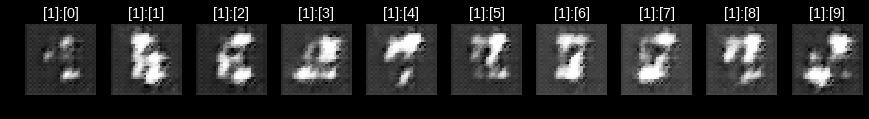

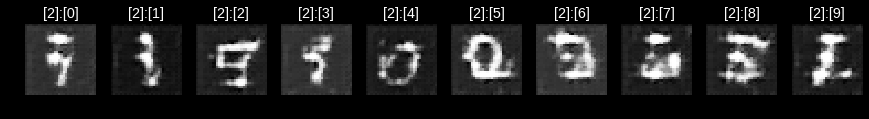

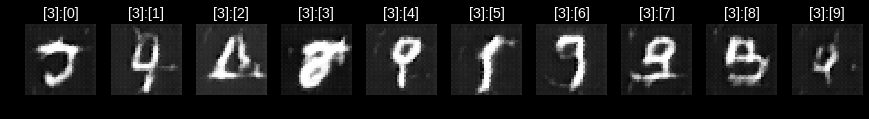

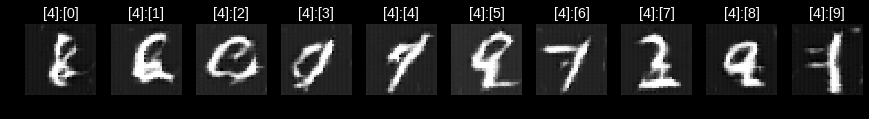

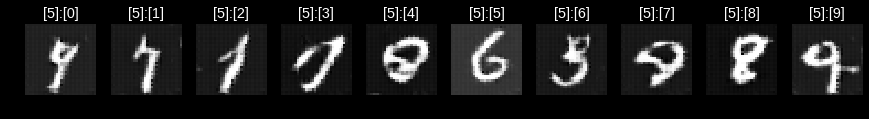

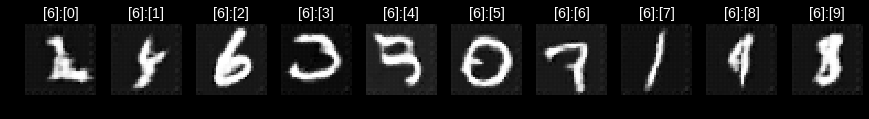

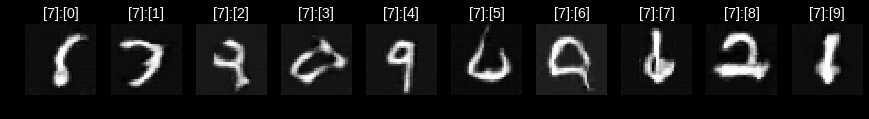

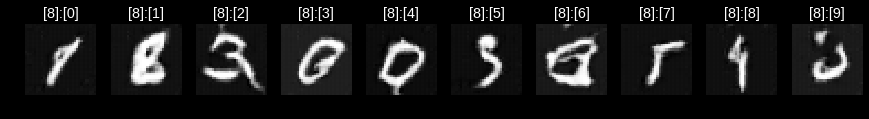

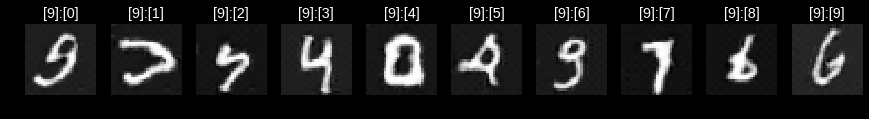

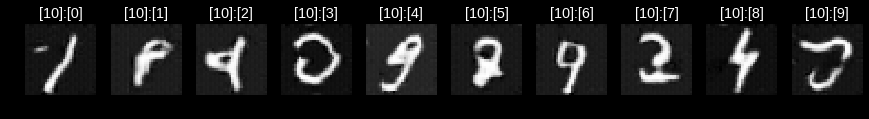

In [9]:
dcgan_trainer.train()